# Iterative solvers

Many methods for discretising PDE operators exist:

- Finite Differences
- Finite Volume Methods
- Finite Element Methods
- Discontinuous Galerkin

So far we have only looked at finite difference methods. One thing they have in common is that they all transform a PDE into a large linear system. For some time-stepping schemes, e.g. explicit Euler, we do not need solve the system. However, in general, we need to be able to quickly solve the resulting linear system.

## Direct Solvers
Let's assume that we have N degrees of freedom (i.e. entries in our vector), then Gaussian elimination will scale with O(N^2). Conversely, a highly optimised sparse direct solvers can reach O(N^3/2). Without taking into account round-off errors, direct methods give an exact solution.

## Iterative Solvers

Iterative solvers consist only of matrix-vector products and generally only give an approximate solution. However, using iterative solvers we can easily achieve a scaling of O(N) when solving the linear system.

There are two major classes of iterative solvers:
1. Stationary iterative solvers, e.g. relaxation methods
2. Krylov subspace methods, e.g. CG, preconditioned CG

In this notebook we will cover some basic relaxation methods. We want to solve a linear system of equations
$Ax=b$                                    
by finding a sequence of approximate solutions $x^{(k)}$ that converge to the true solution $x$.
The error is given by
$$e^{(k)}:=x−x^{(k)}$$

Since the true solution is generally not known, it is not possible to compute the error. We need to introduce a measure for the error that is computable. Let us define the residual:
$$r^{(k)} := b - Ax^{(x)}$$

The residual and the error have a simple relationship:
$$r^{(k)} := b - Ax^{(x)} = Ax - Ax^{(k)} = A(x-x^{(k)})= Ae^{(k)}$$

We can now repose the linear system using the residual:
$$r^{(k)} = Ae^{(k)}$$
This form of the equation is referred to as the residual equation.

From now on we always work with the residual equation $r^{(k)}=Ae^{(k)}$ instead of $Ax^{(k)}=b$.
We approximate the error $e^{(k)}$ in each step. This gives updates $x^{(k+1)} = x^{(k)} + \tilde e^{(k)}$, where $\tilde e^{(k)}$ is an approximation of the error at this step. But how can we compute the approximations $\tilde e^{(k)}$ using the residual equation?

<b>Idea:</b> Solve an easier equation instead.

Let's introduce a matrix $B$, such that 
1. $B$ is easy to invert, e.g. a diagonal matrix
2. $B$ is similar to $A$ in some sense $A\sim B$. We will define what it means to be similar later on. 
Then we can solve the residual equation for $B$
$$B\hat e^{(k)} = r^{(k)}$$
and use $\hat e^{(k)}$ as an approximation to the error $e^{(k)}$ in our original equation. This gives the iterative scheme:
$$x^{(k+1)} = x^{(k)} + \hat e^{(k)}$$

With this simple iterative scheme in mind we now need to figure out how to choose $B$. Let's start with the simplest possible idea and set $B$ to be the diagonal of $A$. The resulting scheme is called Jacobi relaxation. This choice of $B$ is clearly easy to invert. The open question is whether it is sufficiently similar to $A$ to give a reasonable approximation of the error. To get an idea of that let's try it out. We need to implement the following:

### Jacobi Relaxation

For $k=1...$
- Solve $\mathop{diag}(A) \hat e^{(k)} = r^{(k)}$
- Update $x^{(k+1)} = x^{(k)} + \hat e^{(k)}$
- Update residual $r^{(k+1)} = b - Ax^{(k+1)}$

or, more compactly:
$$x^{(k+1)} = x^{(k)} + \mathop{diag}(A)^{-1} r^{(k)} = x^{(k)} + \mathop{diag}(A)^{-1} (b − Ax^{(k)})$$

Since the most computationally expensive operation in an iterative scheme is generally the matrix-vector product, for implementational purposes, we minimise them. This finally gives:
$x^{(k+1)} = \mathop{diag}(A)^{-1} \left(b - (\mathop{diag}(A)-A) x^{(k)}\right)$

Let's set up two different matrices for the solve

In [1]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from scipy.sparse import diags

N=100
h=1/N
diagonals1 = [-np.ones(N-1), 2*np.ones(N), -np.ones(N-1)]
A1 = diags(diagonals1, [-1, 0, 1]).toarray()/h/h
diagonals2 = [-np.ones(N-1), 2.1*np.ones(N), -np.ones(N-1)]
A2 = diags(diagonals2, [-1, 0, 1]).toarray()/h/h

and a random right hand side

In [2]:
b = 20*np.matlib.rand(N,1)

Solving (with an inbuilt direct) solver

In [3]:
ex1 = np.linalg.solve(A1,b)                                # solve system
Y1 = np.vstack((np.array([[0]]),ex1,np.array([[0]])));      # add Dirichlet boundary
ex2 = np.linalg.solve(A2,b)                                # solve system
Y2 = np.vstack((np.array([[0]]),ex2,np.array([[0]])));      # add Dirichlet boundary

Now we can implement the Jacobi relaxation:

Residual 60.9682399728097


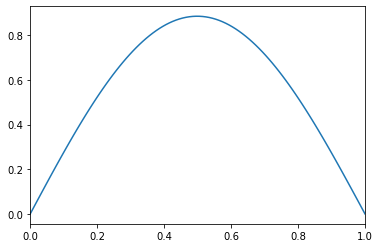

In [4]:
def jacobiRelaxation(A, b, x0, maxIter):
    D = np.diag(np.diag(A))          # Define D_A
    D_inv = np.diag(1 / np.diag(D))  # precompute inverse
    x = x0
    for i in range(maxIter):
        x_new = np.dot(D_inv, b - np.dot(A-D, x)) # Jacobi Relaxation
        if(i == maxIter-1):
            print("Residual", np.linalg.norm(b - np.dot(A,x_new)))
        x = x_new
    return x

x0 = np.zeros(N).reshape(-1,1)    # initial guess
Y = jacobiRelaxation(A1,b,x0,1000); #solve
Y = np.vstack((np.array([[0]]),Y,np.array([[0]]))) # add Dirichlet conditions
X = np.linspace(0,1,Y.size)
#plot
fig, ax = plt.subplots()
ax.set_xlim([0, 1])
ax.plot(X, abs(Y-Y1));

### Jacobi Relaxation
In order to implement the Jacobi relaxation we require some additional storage required (x_new). However, x and x_new can be computed in any order (and in parallel).

### Convergence Analysis
To see when the iteration converges let's repose the scheme (yet again):
$$x^{(k+1)} = (I - \mathop{diag}(A)^{-1} A) x^{(k )} + \mathop{diag}(A)^{-1} b =: Mx^{(k )} + Nb$$
- where $I$ is the identity matrix,
- $M:= I - \mathop{diag}(A)^{-1} A$ and $N= \mathop{diag}(A)^{-1}$

Using this formulation we can derive an iterative scheme for the error $e^{(i)} := x - x^{(i)}$:
$$e^{(i+1)} = x - x^{(i+1)} =  x - M x^{(i)} - N b$$

This means that
\begin{align} e^{(i+1)} &= M x + N b - M x^{(i)} - N b  \\ &= M x - M x^{(i)} = M e^{(i)} \\ \Rightarrow  e^{(i)} &= M^i e^{(0)}. \end{align}

Or in other words, the convergence depends on how quickly multiplication with M reduces the error. Now we need a good way of computing that.

Let's assume we know the  eigenvalues $\mu_k$ and eigenvectors $v_k$ of iteration matrix $M$. Then an a multiplication with M reduces to a multiplication with a scalar:
$$M v_k = \mu_k v_k  \quad\Rightarrow \quad M \bigl( \sum_k \alpha_k v_k \bigr) = \sum_k \alpha_k M v_k  = \sum_k \mu_k \alpha_k v_k $$
           
Now we can write the error as a sum of eigenvectors:
$$e^{(0)} = \sum_{k} \alpha_k v_k,$$ 
And compute the effect of $i$ multiplications with $M$:
$$M^i e^{(0)} = M^i \bigl( \sum_k \alpha_k v_k \bigr) =\sum_k (\mu_k)^i \alpha_k v_k $$
                        
Clearly, the scheme can only converge if $\left| \mu_k \right| < 1$ for all $k$. And the closer the eigenvalues $\mu_k$ are to zero, the faster the convergence will be. The overall convergence will dominated by largest eigenvalue $\mu_k$.

For Jacobi relaxation $M:= I - \mathop{diag}(A)^{-1} A$. The eigenvalues of $M$ are less than one if the matrix is strictly diagonally dominant, i.e. if
$$|a_{ii}|>\sum_{i\neq j}|a_{ij}|,~~\forall i.$$

### Gauss-Seidel Relaxation

Following the same general algorithm as Jacobi we can create a somewhat more broadly applicable smoother. We replace the diagonal of A with lower triangular part of A.
So, here: $B = L_A$ (lower triangular part of A)

Directly inverting B is expensive, <em>but</em>, computing y with $By = b$ is cheap. We can simply use forward substitition to compute y
$$y_1 = \frac{b_1}{A_{11}},~ y_2 = \frac{b_2 - A_{21} y_1}{A_{22}},~  \dots , ~
  y_m = \frac{b_m - \sum_{i=1}^{m-1} A_{mi}y_i}{A_{mm}}.$$
  
#### Iteration formulas in matrix-vector notation:
- $ x^{(k+1)} = x^{(k)} + L_A^{-1} r^{(k)}
                   = x^{(k)} + L_A^{-1} \left( b - A x^{(k)} \right)$

#### for implementation:
- $x^{(k+1)} = L_A^{-1} \left( b - ( A - L_A ) x^{(k)} \right)$
- After inserting substition rule: 
    - $x^{(k+1)}_m = A_{mm}^{-1}\left(b_m - \sum_{i=1}^{N}A_{mi}x^{(k)}_i + A_{mm}x^{(k)}_m \right)$

#### for analysis:
- $x^{(k+1)} = \left( I - L_A^{-1}A \right) x^{(k)}  + L_A^{-1} b
                   =: M x^{(k)} + N b$

In [5]:
def gaussSeidelRelaxation(A, b, x0, maxIter):
    x = x0  # initial guess
    res = b - np.dot(A,x)                        # initial residual
    for i in range(maxIter):
        for j in range(0,N):
            x[j] = (1/A[j,j]) * (b[j] - np.dot(A[j,:],x) + A[j,j]*x[j]); # forward substitution and update
        res = b - np.dot(A,x)  
        if(i == maxIter-1):
            print("Residual", np.linalg.norm(res)) 
    return x

Residual 0.006519740792442842


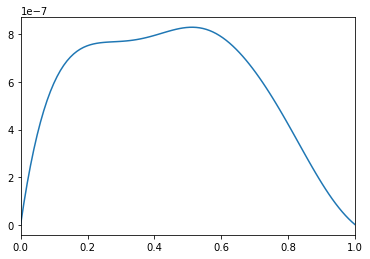

In [6]:
x0 = np.zeros(N).reshape(-1,1)    # initial guess
Y = gaussSeidelRelaxation(A2,b,x0,100);
Y = np.vstack((np.array([[0]]),Y,np.array([[0]])))
X = np.linspace(0,1,Y.size)
#plot
fig, ax = plt.subplots()
ax.set_xlim([0, 1])
ax.plot(X, abs(Y-Y2));

#### Gauss-Seidel Relaxation

In this implementation we do not need an additional vector $x_{new}$ . Instead we compute the solution x in place.

#### Properties
- matrix $A$ needs to be symmetric positive definite (or strictly diagonally dominant)
- usually faster convergence than Jacobi

### Successive-Over-Relaxation (SOR)
We see that the Gauss-Seidel and Jacobi corrections are “too small”. To compensate this we add an over-relaxation-factor $\alpha$ and multiply our correction with it.

For Jacobi Method this gives:
- $x_i^{new} = x_i + \alpha \cdot A_{ii}^{-1}( b_i - \sum_{j=1}^N  A_{ij} x_j)$
- for 2D Poisson model problem (e.g. matrix A1):
    - optimal $\alpha \approx 1.7$ improves convergence: $O(n^2) \to O(n^{3/2})$

Residual 4.413711522318904e-07


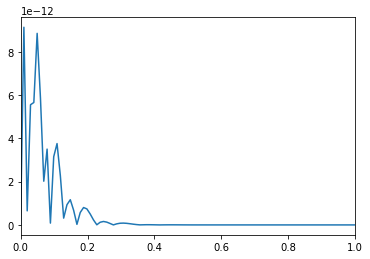

In [7]:
def SOR(A, b, alpha, x0, maxIter):
    x = x0  # initial guess
    xnew = np.zeros(N).reshape(-1,1)
    for i in range(maxIter):
        for j in range(0,N):
            xnew[j] =  x[j] + (alpha/A[j,j]) * (b[j] - np.dot(A[j,:],x));
        if(i == maxIter-1):
            print("Residual", np.linalg.norm( b - np.dot(A,x))) 
        x = xnew
    return x

x0 = np.zeros(N).reshape(-1,1)    # initial guess
Y = SOR(A2,b,1.7,x0,100);
Y = np.vstack((np.array([[0]]),Y,np.array([[0]])))
X = np.linspace(0,1,Y.size)
#plot
fig, ax = plt.subplots()
ax.set_xlim([0, 1])
ax.plot(X, abs(Y-Y2));

### Relaxation Methods: Summary

How about performance? For the methods we have looked at so far it is usually quite slow. In the code example with size  only $N=100$: 
1. Jacobi:needed 140 of iterations to reach tol=$1e-4$
2. Gauss-Seidel: needed $70$ iterations tol=$1e-4$
3. SOR: needed $36$ iterations tol=$1e-4$

## Back to the model problem
Let's go back to our model problem, the Poisson equation. In 1D:

\begin{align}
- \partial_x^2 u (x) &= 0\text{ on }\Omega = (0, 1),\\
u(0) &= u(1) = 0
\end{align}

We will start with a 0 right hand side and boundary conditions. Note that in this case the solution will be zero. Nevertheless, looking at the results will be useful for seeing why Jacobi reduces high-frequency components efficiently.

We discretise on a uniform grid of mesh size h = 1/(N+1). The grid points are $x_j := jh$, with $j = 1, . . . , N$. As before we compute values at grid points $u_j  = u(x_j)$ and use a second-order accurate approximation:
$$\partial_x^2 u(x) \approx \frac{u(x+h)-2u(x)+u(x-h)}{h^2}$$

Recall that the Jacobi relaxation will give the scheme:
$u_j^{(k +1)} = \frac{1}{2}(u_{j+1}^{(k)} + u_{j−1}^{(k)})$
In this case, we know that the exact solution will be zero, so the error is just
$$e_j^{(k)} = 0 - u_j^{(k)}$$

### Eigenvalues and -vectors of $A$ (see exercise)
- eigenvalues: $$\lambda_k = \frac{4}{h^2} \sin^2\bigl(\frac{k \pi}{2n}\bigr) = \frac{4}{h^2} \sin^2\bigl(\frac{k \pi h}{2}\bigr)$$
- eigenvectors: $$v^{(k)} = \bigl( \sin(k \pi j / n) \bigr)_{j=1,\dots,n-1}$$
    - both for $k=1,\dots, N$

### Eigenvalues and -vectors of $M$
Recall that the iteration matrix for a Jacobi iteration was:
$$M = I - D_A^{-1} A = I - \frac {h^2}{2} A$$

Using the computation for the eigenvalues of $A$ we can now compute the eigenvalues of $M$. We know that
$$\mathop{diag}\left({A}\right)^{-1} = \frac{h^2}{2}I.$$
It can be easily shown that the following is true for every $k=1,\dots,N-1$:
$$Mv_k = \left(I-\frac{h^2}{2}A\right)v_k = \left(1-\frac{h^2}{2}\lambda_k\right)v_k =: \mu_kv_k.$$

Hence, the eigenvectors of $M$ are $v_k$ and the eigenvalues are
$$ \mu_k = 1-\frac{h^2}{2}\lambda_k = 1-\frac{h^2}{2}\frac{4}{h^2}\sin^2\left(\frac{k\pi h}{2}\right) = 1-2\sin^2\left(\frac{k\pi h}{2}\right).$$

As derived in the previous notebook, the (point-wise) error in the $n$-th iteration is
$$
  e^{(n)} = M^ne^{(0)}.
$$
We may decompose any error into a linear combination of eigenvectors $v_k$, as they are a basis of $\mathbb{R}^{N-1}$. That is,
$$
  e^{(0)} = \sum_{k=1}^{N-1}\alpha_k v_k.
$$
Inserting this into the error equation yields
$$
  e^{(n)} = M^n\left(\sum_{k=1}^{N-1}\alpha_k v_k\right) = \sum_{k=1}^{N-1}\alpha_k M^nv_k = \sum_{k=1}^{N-1}\alpha_k \mu_k^nv_k.
$$
If we take the norm on both sides and use the triangle inequality we obtain
\begin{equation}
  \|e^{(n)}\| = \left\|\sum_{k=1}^{N-1}\alpha_k \mu_k^nv_k\right\| \leq \sum_{k=1}^{N-1}|\alpha_k| |\mu_k|^n\left\|v_k\right\|.
\end{equation}

This leads to the following interpretation: As the eigenvectors follow a sine function, we may think
of them as waves with a single frequency. The error can be decomposed into frequency components, similar to a Fourier analysis.
The eigenvalues then give an upper bound on the error reduction of each frequency component. So even if we are unaware of the error (because
the true solution is unknown in general) and of the $\alpha_k$ values, we still know that the error in the $k$-th frequency component 
is reduced by the factor $|\mu_k|$ in one iteration.

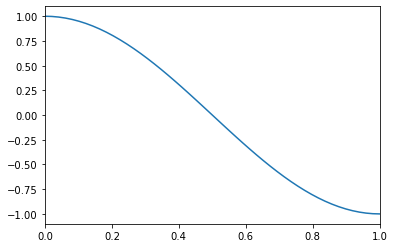

In [15]:
import math
fig, ax = plt.subplots()
ax.set_xlim([0, 1])
x  = np.linspace(0,1)
ax.plot(x, 1-2*np.sin(x*math.pi/2)*np.sin(x*math.pi/2))

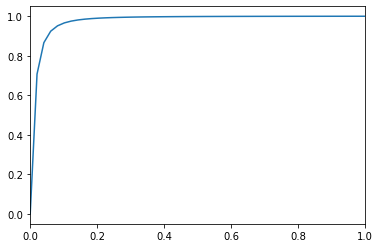

In [19]:
fig, ax = plt.subplots()
ax.set_xlim([0, 1])
N  = np.linspace(2,100)
ax.plot(x, 1-2*np.sin(1/N*math.pi/2)*np.sin(1/N*math.pi/2))

### SOR
Exercise: We are interested in removing the “high frequencies”, say $N/2 \leq k \leq N$. Show that $\omega = 2/3$ is the best choice in the sense that it solves 
$$ \omega = \mathop{arg} \min_\omega' \max_k |\lambda_k|,$$
What is the reasoning of this criterion?

When seeing a minimax problem, one can think of it in terms of a protagonist and an antagonist.
Here, the protagonist (you) tries to minimise the eigenvalues of $M$ such that the error is reduced fastest
in each iteration. Then, the antagonist (Murphy) picks the largest eigenvalue, i.e. the one leading to the worst error reduction.
(In a sense, Murphy picks the worst of all the things that can go wrong.)
The good thing about a minimax problem is that you get a guaranteed bound that holds even in the worst case.

Coming to the problem at hand: As the eigenvalues are monotonically decreasing, it is sufficient to take the maximum
over the first and the last eigenvalue in the interval, i.e.
$$
\omega = \mathop{argmin}_{\omega'}\max\left\{|\lambda_{N/2}(\omega')|, |\lambda_{N}(\omega')|\right\}
= \mathop{argmin}_{\omega'}\max\left\{|1-\omega'|, |1-2\omega'|\right\}.
$$
The extreme points of the maximum function must be at at one of the kinks or intersection points of $|1-\omega'|$ and $|1-2\omega'|$, because otherwise
one could follow the slope to a smaller or larger point (hint: create a plot of $\max\left\{|\lambda_{N/2}(\omega')|, |\lambda_{N}(\omega')|\right\}$).
Here, the only relevant case (for finding the minimum) is 
$$
  \lambda_{N/2} = 1-\omega' = -\left(1-2\omega'\right) = -\lambda_{N},
$$
which leads to $\omega = 2/3$. With $\omega = 2/3$, the maximum absolute eigenvalue for the high frequencies is $1/3$. Hence,
all errors in high frequencies ($k \geq N/2$) are guaranteed to be three times lower after one iteration.


### Observation
- The <b>high</b> frequency part (with respect to the underlying grid) is reduced quite quickly.

- The <b>low</b> frequency part (w.r.t. the grid) decreases only very slowly; actually the slower, the finer the grid is.

- Smoothers good for reducing high-frequency errors
- Otherwise very slow convergence
- Gauss-Seidel usually slightly faster than Jacobi
        
#### Our next topics:
1. How slow are the methods exactly?
2. What is the underlying reason?
3. Is there a fix?